In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [11]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import time

import glob
import numpy as np
import matplotlib.pyplot as plt
from utils import sample_files
from utils import decoder_files_to_tensors, get_best_model_timestamp
from utils import unnormalize_params
from utils import sample_files
from models import Decoder

# data_dir = '/eos/user/k/kiliakis/tomo_data/datasets_decoder_02-12-22'
data_dir = './tomo_data/datasets_decoder_TF_03-03-23'
dataset_percent = 0.01
normalization = 'minmax'
ps_normalize = 'off'

var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
train_cfg = {
    'loss_weights': [0, 1, 2, 3, 4, 5, 6, 7],
}

# timestamp = 'best_decoder_TF'
timestamp = '2023_03_09_16-09-44'



In [10]:
# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent)

start_t = time.time()
# read input, divide in features/ label, create tensors
x_test, y_test = decoder_files_to_tensors(
    file_names, normalization=normalization, ps_normalize=ps_normalize)
total_time = time.time() - start_t
print(
    f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')



Elapsed time: 21.202, Per file: 0.072


In [12]:
# Model to load
print('Decoder: ', timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
assert os.path.exists(weights_dir)

decoder = Decoder()
decoder.load(weights_dir)


Decoder:  2023_03_09_16-09-44


In [ ]:
# drop column from y_train, y_valid
# x_test_red = tf.concat([tf.expand_dims(tf.gather(x_test, i, axis=1), axis=1)
#                      for i in train_cfg['loss_weights']], -1)
# print('x_test shape: ', x_test_red.shape)

In [13]:
# Evaluate the model on the test and validation data
test_loss = decoder.model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss:.4e}')

# get predictions
test_pred = decoder.model.predict(x_test, verbose=False)
y_test = np.array(y_test)

# Calculate error per variable
# mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')

# valid_loss = decoder.evaluate(x_valid, y_valid)
# print(f'Valid loss: {valid_loss:.4e}')
# valid_pred = decoder.predict(x_valid, verbose=False)

10/10 [==============================] - 0s 30ms/step - loss: 4.4066e-06
Test loss: 4.4066e-06


0.71128124
0.0


Text(0.5, 1.0, 'Mean Diff.')

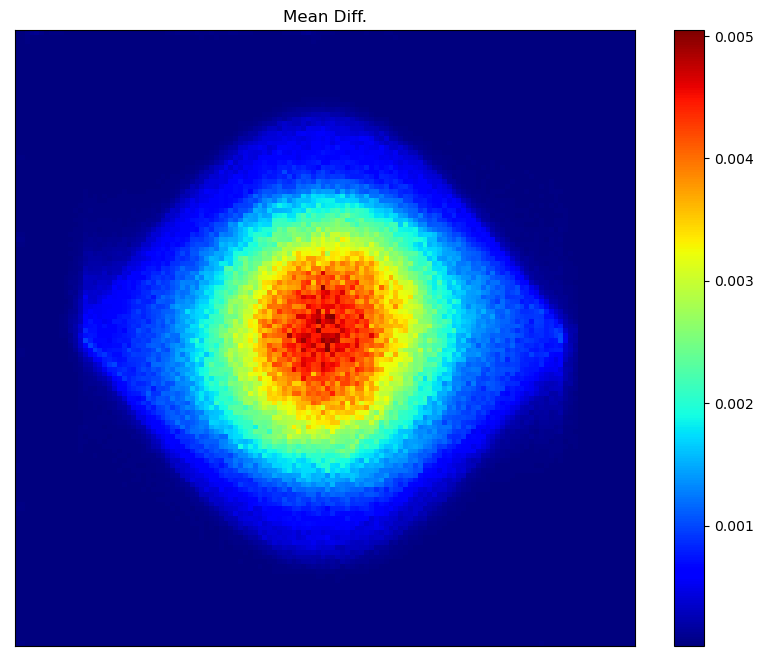

In [14]:
%matplotlib inline

print(np.max(y_test))
print(np.min(y_test))
mse_image = np.mean((y_test - test_pred) ** 2, axis=0)
mse_image = mse_image.reshape((128, 128))

me_image = np.mean(np.abs(y_test - test_pred), axis=0)
me_image = me_image.reshape((128, 128))

# Create 3x3 grid of figures
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))

ax.set_xticks([])
ax.set_yticks([])
# show the image
plt.imshow(me_image, cmap='jet', aspect='auto')
plt.colorbar()
# Set the label
# title = ','.join([f'{num:.1f}' for num in samples_X[i]])
ax.set_title(f'Mean Diff.')

# for i in range(len(axes)):
#     ax = axes[i]


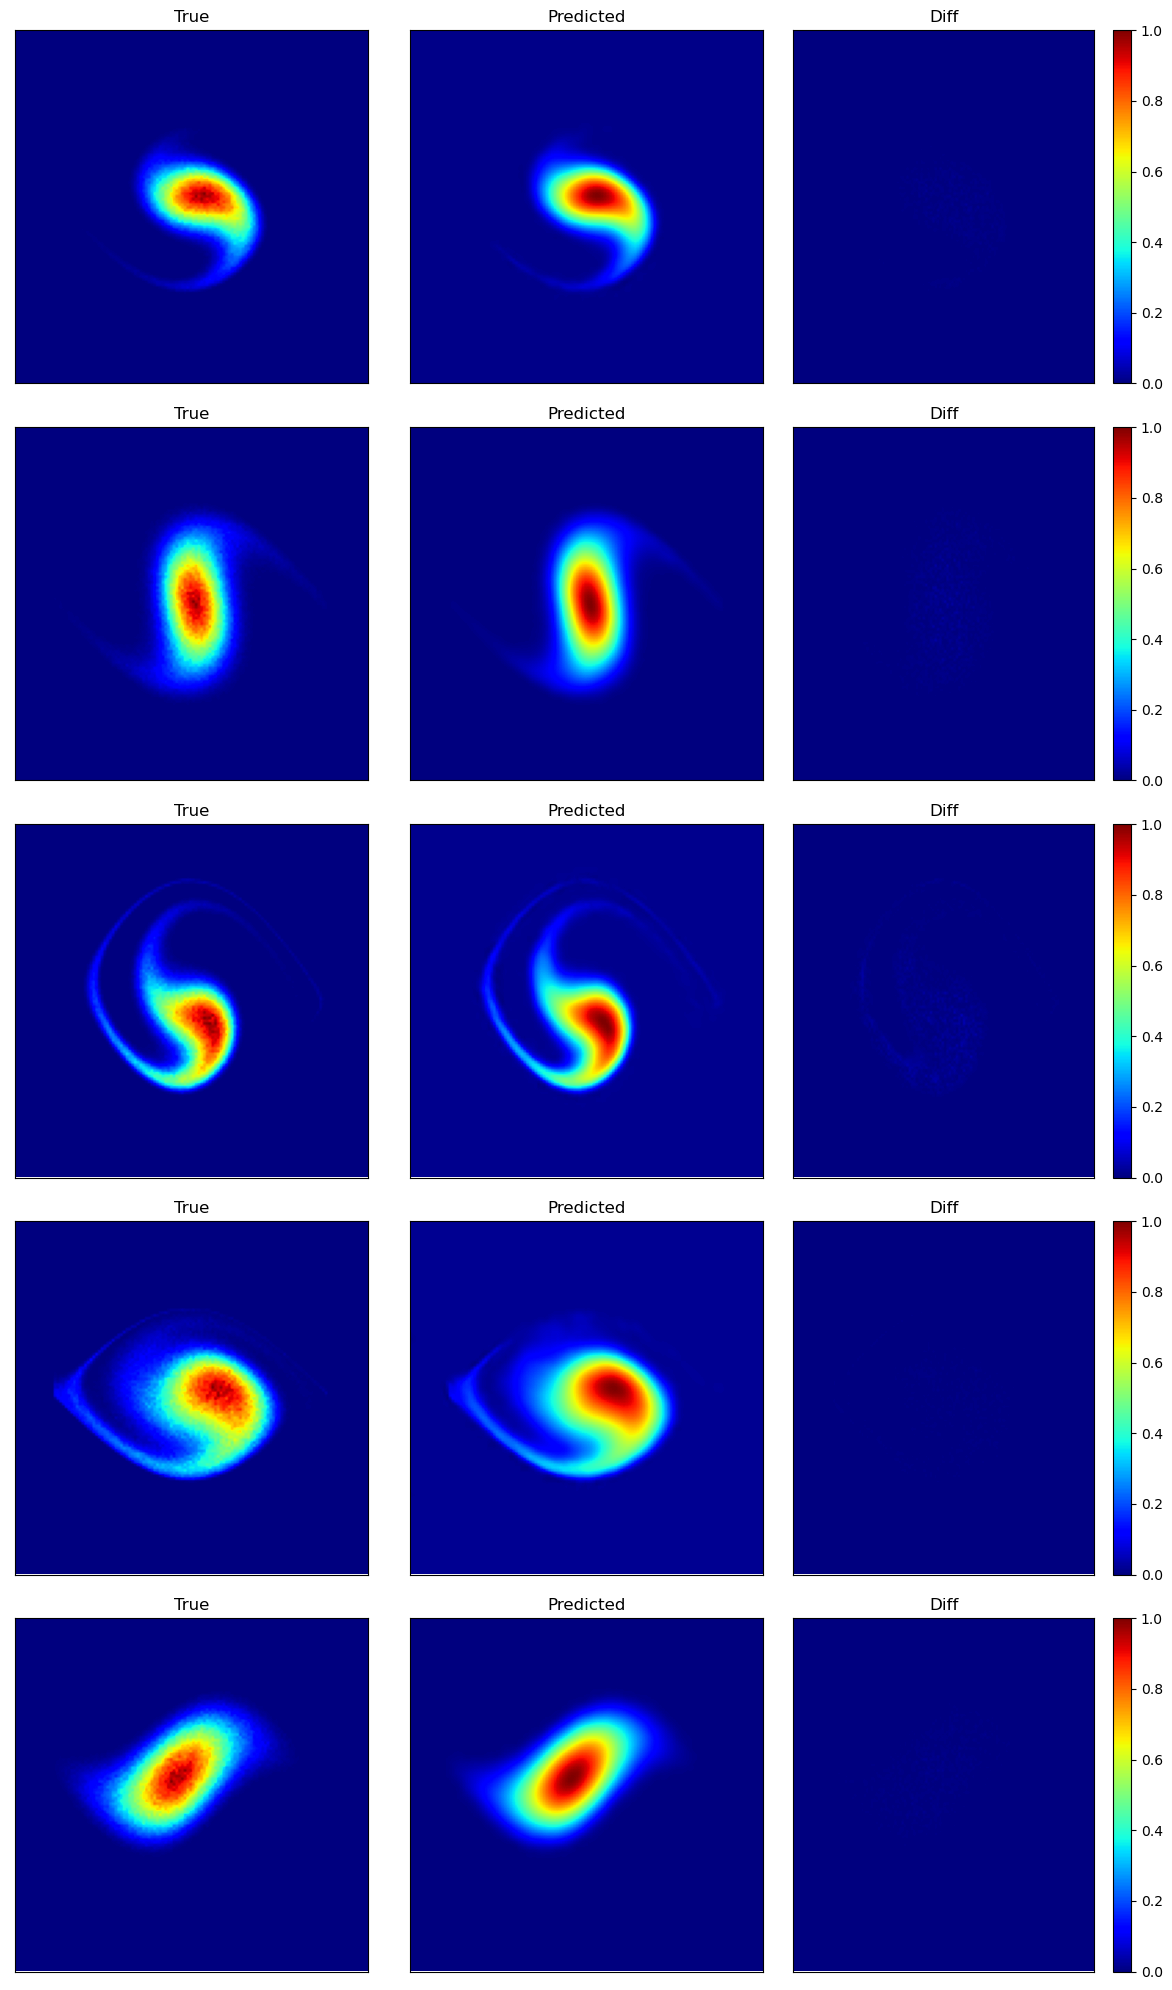

In [18]:
%matplotlib inline
# plot some of the outputs

nrows = 5
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(y_test)),
                          size=nrows, replace=False)

samples_real = y_test[sample]
samples_pred = test_pred[sample]

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(12, 20))
# axes = np.ravel(axes)
for i in range(nrows):
    ax = axes[i][0]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_real[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'True')
    plt.tight_layout()

    ax = axes[i][1]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_pred[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'Predicted')
    plt.tight_layout()

    ax = axes[i][2]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    plt.imshow(np.abs(samples_real[i] -
              samples_pred[i]), cmap='jet', vmin=0, vmax=1,
              aspect='auto')
    plt.colorbar()
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_X[i]])
    ax.set_title(f'Diff')
    plt.tight_layout()
